# Airbnb Roomcheck

## Intention:
The idea of this notebook is to answer some fundamental questions, when it comes to book a room in a city.

#### The Question:
1. What is the best time to book, according the price?
2. What is the best time to book, according to availabilty?
3. What is the main reason for price per accommodation?
4. What is the price development in relation to score rate and the same facility of an accommodation?
5. What are the top accommodations?


#### Used Datasets for analysis:
- calendar.csv
- listings.csv


### Import Libs

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # need to install
%matplotlib inline

#### Basic functions to explore datasets

In [79]:
# Set dataframe columns into a list
def getSchema(df):
    return list(df.columns)
 
# Print columns of the given dataframe
def printInfo(df):
    for col in getSchema(df):
        print(col)
        
    print('\nDf size:\n'+str(df.shape))
    print('\nDatatypes\n'+str(df.dtypes))

# Get columns with null values
def getNullColumns(df, how=0.0):
    if how == 0.0:
        return list(df.columns[df.isnull().mean() == how])
    else:
        return list(df.columns[df.isnull().mean() > how])

# Return csv as dataframe
def readCSV(path):
    return pd.read_csv(path)

#### Analytics functions

In [80]:
# Creates a bar plot of price ranges
def getPriceDevelopment(method):

    #Price development over month: median
    #Group price dataframe by month and calculate the median of the price
    df_price_month = df_price[['date_month','price_float']].groupby('date_month')['price_float'].agg(method).reset_index()

    # Rename columns for readability
    df_price_month.rename(columns={'date_month':'Date','price_float':'Price'}, inplace=True)

    # Plot dataframe as bar plot
    ax = df_price_month.plot.bar(x='Date', y='Price', rot=45,figsize=(10,6),title="Price development: "+method)
    
    
# Create a bar plot groups prices according beds and review score
def getPlotScoreBed(beds=1,score_from = 0, score_to = 10):
    
    # Join dataframe pirce with dataframe listings
    df = pd.merge(df_price,df_list[['id','beds','review_scores_value']], left_on='listing_id', right_on='id')
    
    # Calculate median price
    df = df[['date_month','price_float','beds','review_scores_value']]\
    .groupby(['date_month','beds','review_scores_value'])['price_float'].median().reset_index()

    # Filter beds
    df = df[ df['beds'] == beds]
    
    # Pivot table according to scores
    pivoted = df.pivot(index='date_month', columns='review_scores_value', values='price_float')
    
    # Recreate dataframe
    df = pd.DataFrame(pivoted.to_records())

    # Fill nan with zeros
    df = df.fillna(0)
    df.rename(columns={'date_month':'Date'}, inplace=True)

    cols = list(df.columns) # get columns from df
    cols.pop(0) # remove date column
    
    # Filter score
    x = 0 #set index
    for i in range(0,len(cols)): # begin with one
     
        if ((float(cols[x]) >= float(score_from)) and (float(cols[x]) <= float(score_to))):
            x=x+1
        else:
            cols.pop(x)
            x = x
    
    # Create bar plot
    ax = df.plot(x='Date', y=cols, kind="bar",figsize=(20,10),rot=45, title="Price (median) for beds: " + str(beds))

    # Change x-labels
    for i,col in enumerate(cols):
        cols[i] = 'review score: '+ str(col)
    
    ax.legend(cols);
    
    
# Best accomondations Top x
def bestAccomondations(beds=1,top=3):
    # load dataset
    df_list = pd.read_csv('./data/listings.csv')
    
    # get attributes of interest
    df_satisfaction = df_list[['host_id','id','host_name','name','number_of_reviews','review_scores_value','beds']]
    
    # filter size of rooms by beds
    df_satisfaction = df_satisfaction[df_satisfaction['beds'] == beds]\
    .sort_values(by=['number_of_reviews','review_scores_value'], ascending=False).head(top)
    
    # join with price dataframe
    df_satisfaction = pd.merge(df_satisfaction,df_price[['listing_id','date_month','price_float']], left_on='id', right_on='listing_id')
    
    # calculate median
    df_satisfaction = df_satisfaction\
    .groupby(['host_id','id','host_name','name','number_of_reviews','review_scores_value','beds','date_month'])['price_float']\
    .median().reset_index()#.sort_values(by=['number_of_reviews','review_scores_value'], ascending=False)
    
    #Create new name column
    df_satisfaction['beds'] = df_satisfaction['beds'].astype(str) # change datatype to string
    df_satisfaction['score'] =  ' - score: ' + df_satisfaction['review_scores_value'].astype(str) + ' - number reviews: ' + df_satisfaction['number_of_reviews'].astype(str) # change datatype to string
    df_satisfaction['name'] = df_satisfaction['host_name']+': '+ df_satisfaction['name']+' - beds: ' + df_satisfaction['beds'] + df_satisfaction['score']

    # Pivot table according to scores
    pivoted = df_satisfaction.pivot(index='date_month', columns='name', values='price_float')

    # Recreate dataframe
    df_satisfaction = pd.DataFrame(pivoted.to_records())
    
    df_satisfaction.rename(columns={'date_month':'Date'}, inplace=True) # rename column
   
    return df_satisfaction

#### Business and data understanding of datasets

##### Load dataset

In [81]:
df_calendar = readCSV('./data/calendar.csv')
df_list = readCSV('./data/listings.csv')
df_rev = readCSV('./data/reviews.csv')

#### Provide basic information about datasets

In [82]:
# Information about calendar.csv
printInfo(df_calendar)

print('\nNo null columns: '+str(getNullColumns(df_calendar,0.0)))

print('\nColums with more than 25% nulls: '+str(getNullColumns(df_calendar,0.25)))

print('\nColums with more than 75% nulls: '+str(getNullColumns(df_calendar,0.75)))

listing_id
date
available
price

Df size:
(1393570, 4)

Datatypes
listing_id     int64
date          object
available     object
price         object
dtype: object

No null columns: ['listing_id', 'date', 'available']

Colums with more than 25% nulls: ['price']

Colums with more than 75% nulls: []


In [58]:
# Information about listings.csv
printInfo(df_list)

print('\nNo null columns: '+str(getNullColumns(df_list,0.0)))

print('\nColums with more than 25% nulls: '+str(getNullColumns(df_list,0.25)))

print('\nColums with more than 75% nulls: '+str(getNullColumns(df_list,0.75)))

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_re

In [57]:
# Information about reviews.csv
printInfo(df_rev)

print('\nNo null columns: '+str(getNullColumns(df_rev,0.0)))

print('\nColums with more than 25% nulls: '+str(getNullColumns(df_rev,0.25)))

print('\nColums with more than 75% nulls: '+str(getNullColumns(df_rev,0.75)))

listing_id
id
date
reviewer_id
reviewer_name
comments

Df size:
(84849, 6)

Datatypes
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

No null columns: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name']

Colums with more than 25% nulls: []

Colums with more than 75% nulls: []


##### Result of data observation:
The data, provided by Airbnb is splitted into three datasets.
- calendar.csv -> is dealing with availability, date and price per accomondation 
- listings.csv -> provides descriptive data about every unique accomondation as well as review scores
- reviews.csv -> provides information about the review from a particular visit by the reviewers

All datasets are a mixtures of object dtypes (text) and float/int (numeric).
Main identifiers are 'id' and 'listing_id'. They can be used to join across the datasets.

## Handling with missing values:

##### Dataset Calendar:
The obervation in cell 56 shows, that the colum price has >25% of missing values.
In case, a price is missing but the accomondation is available, the values needs to be filled.

In [74]:
# Check if an accomondation exists, that is available but do not have any price
idx = np.where((df_calendar['available'] == "t") & (df_calendar['price'].isnull()))             
display(df_calendar.loc[idx])

,listing_id,date,available,price


Result: Since the dataset calendar does not have any price which is null but is available, there is no no need to fill nulls.

##### Dataset Listings:
Cell 58 that a lot of columns have >25% missing values. However, non of those columns are from further interest for this analyzation, hence there is no need to fill nulls.

##### Dataset Reviews:
For this analyzation, the dataset is currently not from interest.

## Prepare datasets

#### Create new columns:
In order to be able to group the date by month, a new date columns must be created where the "day" is removed.<br/>
Also, to make some aggregation on price, the datatype must be changed aswell.

In [83]:
# Create new column "date_month" to group datasets not only by day
df_calendar['date_month'] = df_calendar['date'].map(lambda x: x[0:7])

# Get additional columns with numerical datatypes to make some aggregations
# add column "price_float"
df_calendar['price_float'] = df_calendar['price'].str.replace('$', '').str.replace(',','')
df_calendar = df_calendar[df_calendar['available'] == 't']

# add column "available_int" 
df_calendar['available_int'] = df_calendar['available'].str.replace('t', '1').str.replace('f','0')

# change datatype of both columns
df_price = df_calendar.astype({'price_float': 'float64','available_int':'int8'})
df_price[df_price['listing_id']== 656909.0].head()

df_price.head()

,listing_id,date,available,price,date_month,price_float,available_int
0,241032,2016-01-04,t,$85.00,2016-01,85.0,1
1,241032,2016-01-05,t,$85.00,2016-01,85.0,1
9,241032,2016-01-13,t,$85.00,2016-01,85.0,1
10,241032,2016-01-14,t,$85.00,2016-01,85.0,1
14,241032,2016-01-18,t,$85.00,2016-01,85.0,1


## Data Modeling

#### Question 1:
What is the best time to book, according the price?

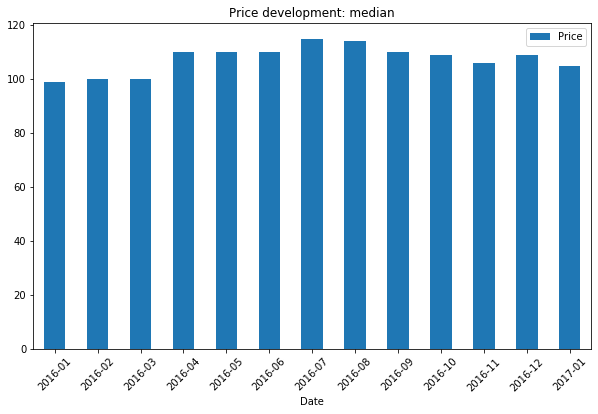

In [84]:
# execute function getPriceDevelopment with parameter median
getPriceDevelopment('median')

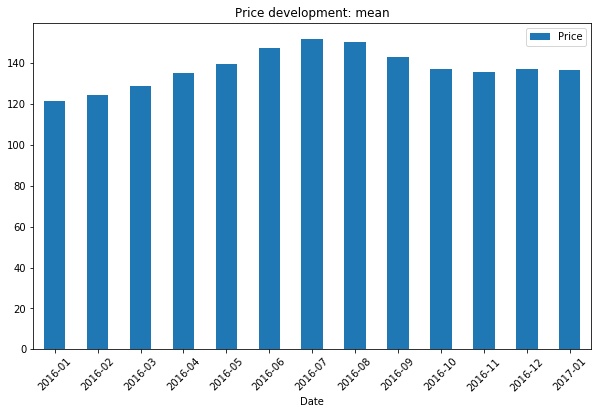

In [85]:
# execute function getPriceDevelopment with parameter mean
getPriceDevelopment('mean')

#### Result:
Both bar charts are showing, that there is a tendency of higher prices during the summer month.
The peak is reached in the month of July and August. 

#### Question 2:
What is the best time to book, according the availability?

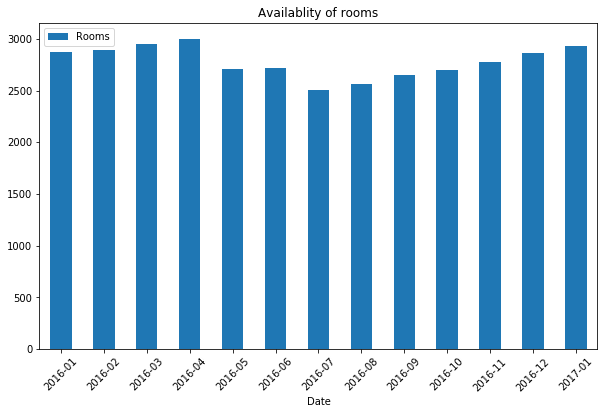

In [86]:
# Availability of rooms
# Group dataframe by month and listing_id and calculate an unique list of listing_id's
df_available = df_price[['date_month','listing_id']].groupby('date_month')['listing_id'].nunique().reset_index()

# Rename columns for readability
df_available.rename(columns={'date_month':'Date','listing_id':'Rooms'}, inplace=True)

# Plot dataframe as bar plot
ax = df_available.plot.bar(x='Date', y='Rooms', rot=45,figsize=(10,6),title="Availablity of rooms")

#### Result:
The bar charts is showing, that there is a decrease of the availability.
The lowest point is reached in July and August. Thus, there must be a negative correlation between <br/>
availability and price development.

#### Question 3:
What is the main reason for price per accommodation?

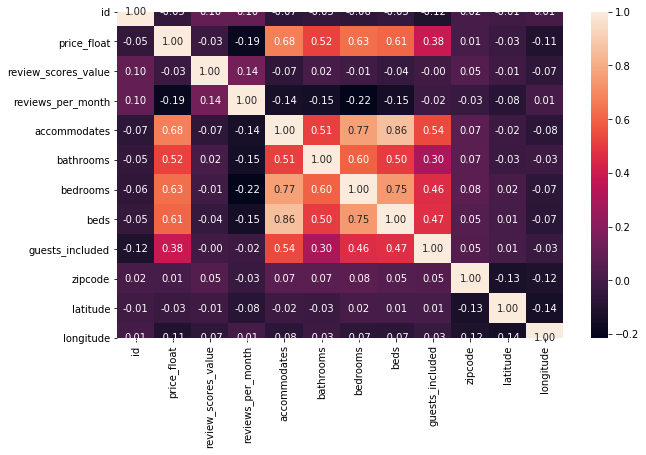

In [87]:
#merge dataframes list and calender
df_corr = pd.merge(df_price, df_list, left_on='listing_id', right_on='id')
df_corr = df_corr[['id','price_float','name','review_scores_value','reviews_per_month','cancellation_policy','jurisdiction_names','accommodates','bathrooms','bedrooms','beds','guests_included','zipcode','latitude','longitude']]

df_corr = df_corr.dropna(subset=['zipcode']) # remove non values
df_corr = df_corr[df_corr['zipcode'].str.isnumeric() == True] # remove non numeric values
df_corr = df_corr.astype({'zipcode': 'int32'}) # change data type

# Set plot size
plt.subplots(figsize=(10,6))

# Create Heatmap
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f");

#### Result:
The correlation matrix provides information, which columns have a strong dependency on other attributes.
The plot denotes, that the strongest influence in price is given by all kind of numeric columns that deals with the facility of the accommodation like number of bathrooms or bedrooms.
Location data lake zip code, latitude or longitude have very less influence. 

#### Question 4.
What is the price development in relation to score rate and the same facility of an accommodation?

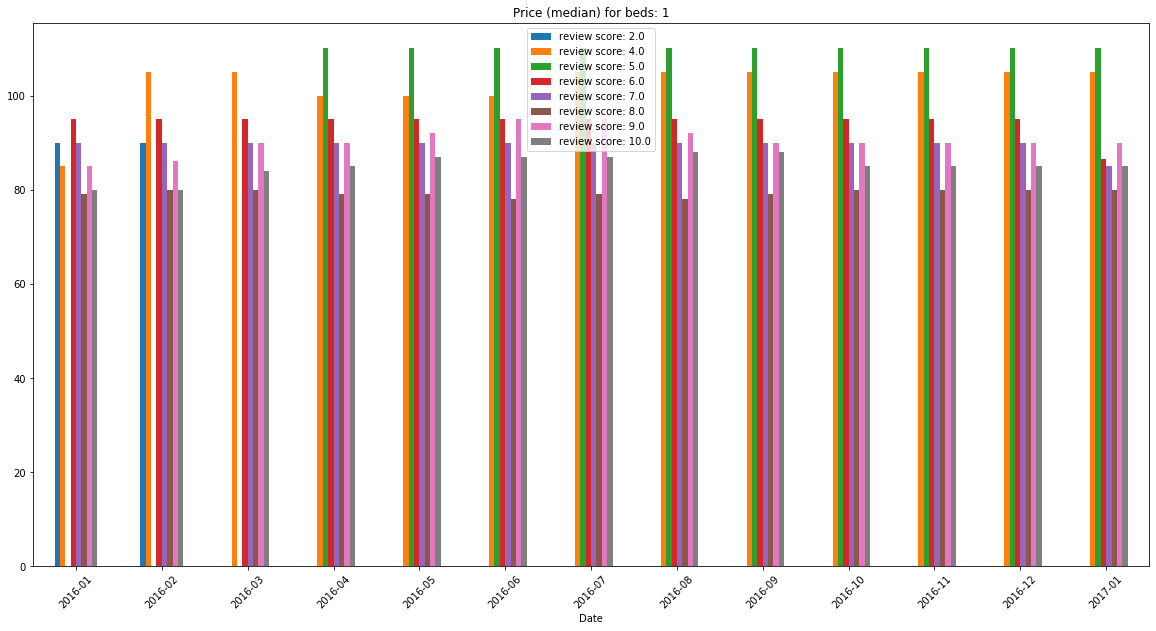

In [89]:
# call function getPlotScoreBed
# Price range for rooms with x beds and y score range
# Price grouped by month and review score
getPlotScoreBed(1,0,10)

#### Result:
The chart indicates, that the reviewers satisfaction is also dependent in price (see bars with review score 2 to 6)
Also, apartments with the review score 10 have always a lower price then apartments with the score of 9.
This supports the assumption, that a low price as a positive influence in satisfaction.

#### Question 5.
What are the top accommodations?

#### bestAccomondations(beds,top)
Returns a bar plot that indicates which rooms are the best within the population of rooms.
The classification of the room is based on the review_scores_value as well as the total amount of reviews grouped by the "host_id", respectively the owner.


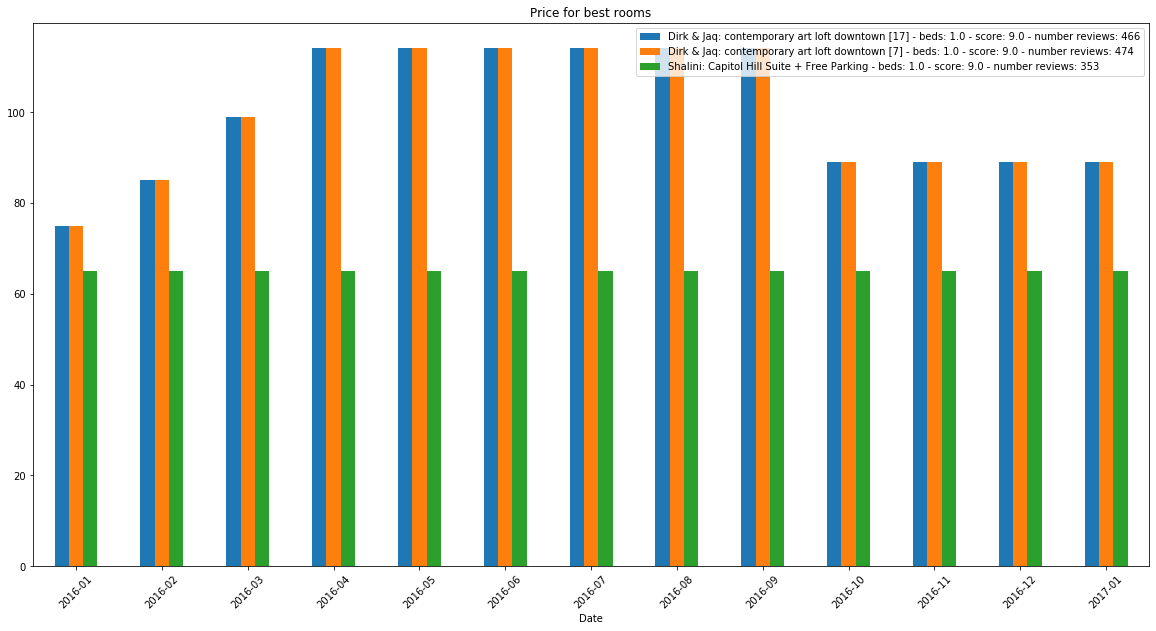

In [90]:
# get data of top rooms    
df_best = bestAccomondations(1,3)


# Build plot
cols = list(df_best.columns) # get list of columns
cols.pop(0) # remove first element

ax = df_best.plot(x='Date', y=cols, kind="bar",figsize=(20,10),rot=45, title="Price for best rooms")

#### Result:
As depicted in the chart, the function with its current setting returns the top 3 of accommodation.
The top rate is evaluated by the top average score rate and the total number of reviews.<br/>

The third is a different owner. However, it seems like third on is more interesting, since the score rate is also nine but the price is continuously stable and lower.

#### End of Notebook